**Aim:**

In this kernel, we aim to use the final model to predict the test dataset.

The models include : XGB, BBRF, and EEC

The algorithm to build connectivity matrix: Mutual information

Scaling method: Standardization

Metrics: AUC, sensitivity, specifity, f1 score, accuracy



### Import packages

In [1]:
import tqdm
import pickle
import sklearn
import numpy as np
import pandas as pd

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from imblearn import pipeline
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier
from sklearn.metrics import (
    roc_auc_score,
    f1_score,
    accuracy_score,
    confusion_matrix
)

from FeatureSelection import FeatureSelector
from Metrics import MetricsCal

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


### Loading the Data

In [2]:
FeatureDir = "../Data/ExtractedFeatures/features_Thr0.9.csv"
with open("../Data/Test_IDs/TestID.pickle", "rb") as file:
    Test_IDs = pickle.load(file)

# Reading the Feature matrix
df = pd.read_csv(FeatureDir)


df_train = df[~df["ScanDir ID"].isin(Test_IDs)]
df_test = df[df["ScanDir ID"].isin(Test_IDs)]

# preparing the feature set and labels
X_train, y_train = df_train.iloc[:, 1:-5], np.array(df_train.loc[:, "DX"])
X_test, y_test = df_test.iloc[:, 1:-5], np.array(df_test.loc[:, "DX"])

### Feature selection

In [3]:
random_state, n_split = 0, 7
ImpFeatures = FeatureSelector(X_train, y_train, random_state, n_split, 1000, 45, 2)
X_train = X_train.loc[:, ImpFeatures]
X_test = X_test.loc[:, ImpFeatures]

print(len(ImpFeatures))

40


### Modeling pipeline

In [4]:
AUC_BRF, Sensitivity_BRF, spcifity_BRF, AucPred_BRF, f1_BRF, ACC_BRF = [], [], [], [], [], []
AUC_EEC, Sensitivity_EEC, spcifity_EEC, AucPred_EEC, f1_EEC, ACC_EEC = [], [], [], [], [], []
AUCs, Specificities , Sensitivities, f1s, ACCs = [], [], [], [], []

for i in tqdm.tqdm(range(50)):



    # Normalizing the train and the test data
    scaler = StandardScaler()

    # Model  <><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
    XGB = XGBClassifier(
                  max_depth= 7,
                  min_child_weight= 5,
                  subsample= 0.5,
                  learning_rate= 0.8,
                  n_estimators= 150,
                  scale_pos_weight= 150
                                    )


    BRF = BalancedRandomForestClassifier(
                                    criterion='entropy', 
                                    max_depth = 10, 
                                    max_features =  'log2', 
                                    min_samples_split = 2, 
                                    n_estimators = 250
                                    )
    EEC = EasyEnsembleClassifier(
        n_estimators =  500
        )


    pipe_EEC = pipeline.Pipeline(steps= [("Scaler", scaler),
                                            ("Model", EEC)])
    pipe_EEC.fit(X_train, y_train)
    Res_EEC = MetricsCal(pipe_EEC, X_test, y_test, "EEC")
    AUC_EEC.append(Res_EEC["AUC"])
    Sensitivity_EEC.append(Res_EEC["Sensitivity"])
    spcifity_EEC.append(Res_EEC["Specificity"])
    AucPred_EEC.append(Res_EEC["AUC_prob"])
    f1_EEC.append(Res_EEC["f1"])
    ACC_EEC.append(Res_EEC["ACC"])
    


      # BRF
    pipe_BRF = pipeline.Pipeline(steps= [("Scaler", scaler),
                                            ("Model", BRF)])
    pipe_BRF.fit(X_train, y_train)
    Res_BRF = MetricsCal(pipe_BRF, X_test, y_test, "BRF")
    AUC_BRF.append(Res_BRF["AUC"])
    Sensitivity_BRF.append(Res_BRF["Sensitivity"])
    spcifity_BRF.append(Res_BRF["Specificity"])
    AucPred_BRF.append(Res_BRF["AUC_prob"])
    f1_BRF.append(Res_BRF["f1"])
    ACC_BRF.append(Res_BRF["ACC"])

    #pipeline <><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
    # # XGB
    pipe_XGB = pipeline.Pipeline(steps= [("Scaler", scaler),
                                            ("Model", XGB)])
    pipe_XGB.fit(X_train, y_train)
    
    y_score = pipe_XGB.predict_proba(X_test)[:, 1]
    y_score2 = pipe_XGB.predict_proba(X_test)[:, 1]

    new_threshold = 0.4

    # Adjust the classification based on the new threshold
    y_pred = (y_score > new_threshold).astype(int)

    cm = confusion_matrix(y_test, y_pred) #confu
    TP = cm[1,1] # true positive 
    TN = cm[0,0] # true negatives
    FP = cm[0,1] # false positives
    FN = cm[1,0] # false negatives
    Specificity = TN/(TN+FP)
    Sensitivity = TP/(FN+TP)

    # Saving each of the metrics
    AUC = roc_auc_score(y_test,y_pred)
    f1 = f1_score(y_test, y_pred)
    ACC = accuracy_score(y_test, y_pred)
    Sensitivities.append(Sensitivity)
    Specificities.append(Specificity)
    AUCs.append(AUC)
    f1s.append(f1)
    ACCs.append(ACC)


100%|██████████| 50/50 [30:53<00:00, 37.08s/it]


Balanced random forest

In [5]:
print(np.mean(AUC_BRF))
print(np.mean(Sensitivity_BRF))
print(np.mean(spcifity_BRF))
print(np.mean(f1_BRF))
print(np.mean(ACC_BRF))

0.5642545454545455
0.37090909090909085
0.7575999999999997
0.384735336364627
0.6394444444444445


EasyEnsemble

In [6]:
print(np.mean(AUC_EEC))
print(np.mean(Sensitivity_EEC))
print(np.mean(spcifity_EEC))
print(np.mean(f1_EEC))
print(np.mean(ACC_EEC))

0.5491272727272727
0.3654545454545455
0.7327999999999999
0.37060041407867494
0.6205555555555555


XGB

In [7]:
print(np.mean(AUCs))
print(np.mean(Specificities))
print(np.mean(Sensitivities))
print(np.mean(f1s))
print(np.mean(ACCs))

0.7236363636363637
0.7199999999999999
0.7272727272727273
0.6153846153846154
0.7222222222222221


## Percision recall figure

In [8]:
# Normalizing the train and the test data
scaler = StandardScaler()

# Model  <><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
XGB = XGBClassifier(
              max_depth= 7,
              min_child_weight= 5,
              subsample= 0.5,
              learning_rate= 0.8,
              n_estimators= 150,
              scale_pos_weight= 150
                                )

pipe_XGB = pipeline.Pipeline(steps= [("Scaler", scaler),
                                        ("Model", XGB)])
pipe_XGB.fit(X_train, y_train)                                        
y_score_XGB = pipe_XGB.predict_proba(X_test)[:, 1]
new_threshold = 0.4

# Adjust the classification based on the new threshold
y_proba = (y_score_XGB > new_threshold).astype(int)


# <><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
BRF = BalancedRandomForestClassifier(
                                criterion='entropy', 
                                max_depth = 10, 
                                max_features =  'log2', 
                                min_samples_split = 2, 
                                n_estimators = 250
                                )

pipe_BRF = pipeline.Pipeline(steps= [("Scaler", scaler),
                                        ("Model", BRF)])
pipe_BRF.fit(X_train, y_train)                                        
y_score_BRF = pipe_BRF.predict_proba(X_test)[:, 1]

# <><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
EEC = EasyEnsembleClassifier(
    n_estimators =  500
    )
pipe_EEC = pipeline.Pipeline(steps= [("Scaler", scaler),
                                        ("Model", EEC)])
pipe_EEC.fit(X_train, y_train)                                        
y_score_EEC = pipe_EEC.predict_proba(X_test)[:, 1]

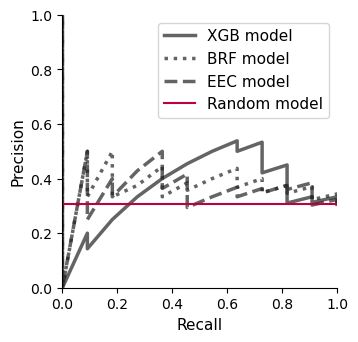

In [11]:
precision_XGB, recall_XGB, thresholds_XGB = precision_recall_curve(y_test, y_score_XGB)
precision_BRF, recall_BRF, thresholds_BRF = precision_recall_curve(y_test, y_score_BRF)
precision_EEC, recall_EEC, thresholds_EEC = precision_recall_curve(y_test, y_score_EEC)

no_skill = np.sum(y_test) / len(y_test)  # Calculate the ratio of positive samples in y_test

CM = 1/2.54

# Create precision recall curve
fig, ax = plt.subplots(figsize=(9*CM,9*CM))
ax.plot(recall_XGB, precision_XGB, color='#232324', linestyle='solid', alpha=0.7, linewidth=2.5)
ax.plot(recall_BRF, precision_BRF,  color='#232324', linestyle=':', linewidth=2.5, alpha=0.7)
ax.plot(recall_EEC, precision_EEC, color='#232324', linestyle='--', linewidth=2.5, alpha=0.7)
ax.plot([0, 1], [no_skill, no_skill], linestyle='-', label='No Skill', color="#BF003F")

# Add axis labels to the plot
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)
ax.set_ylabel('Precision', fontsize=11)
ax.set_xlabel('Recall', fontsize=11)
ax.legend(["XGB model", "BRF model", "EEC model", "Random model"], fontsize=11)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(labelsize=10)

plt.savefig("/home/zaman/Desktop/thesis new documents/AVIN/AVIN_percision_recall2.pdf", 
            dpi=450,
            bbox_inches="tight")
plt.show()